In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
## Importing Libraries
import shutil
import cv2
import zipfile
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
shutil.copyfile('/content/drive/MyDrive/Camouflage_Detection/kaggle.json','/content/kaggle.json')

'/content/kaggle.json'

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! kaggle datasets download -d boatshuai/cod10k-v3

Dataset URL: https://www.kaggle.com/datasets/boatshuai/cod10k-v3
License(s): apache-2.0
100% 2.25G/2.26G [01:31<00:00, 27.9MB/s]
100% 2.26G/2.26G [01:32<00:00, 26.3MB/s]


In [ ]:
with zipfile.ZipFile('/content/cod10k-v3.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [8]:
## Defining Functions

## To Read an image
def apply_visual_attention(path):
    img = cv2.imread(path, 0)
    return img

## To convert an image from BGR to Gray
def feature(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image


## To load a limited number of Image and Mask from Directory
def load_data(image_path, gt_path,maxi):
    img_size2=(512,512)
    images = []
    gt_instances = []
    c=0
    for filename in sorted(os.listdir(image_path)):
        c+=1
        if(c>=maxi):
            break
        if filename.endswith('.jpg'):
            # Load image and resize to (256,256)
            img=apply_visual_attention(os.path.join(image_path , filename))
            img = cv2.resize(img, img_size2)
            images.append(img)
            # Load ground truth instance and resize to (256,256)
            gt = cv2.imread(os.path.join(gt_path ,filename[:-4] + '.png'), cv2.IMREAD_GRAYSCALE)
            gt = cv2.resize(gt, img_size2, interpolation=cv2.INTER_LINEAR)
            gt_instances.append(gt)
    return np.array(images), np.array(gt_instances)


def build_generator(input_shape):
    model = Sequential()
    # Encoder
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), input_shape=input_shape, padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Dropout(0.5))
    # Decoder
    model.add(Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid'))

    # Output
    model.add(Conv2D(1, (1, 1), activation='sigmoid'))

    return model

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


In [ ]:
train_image_path = '/content/COD10K-v3/Train/Image'
train_gt_path = '/content/COD10K-v3/Train/GT_Object'
test_image_path = '/content/COD10K-v3/Test/Image'
test_gt_path = '/content/COD10K-v3/Test/GT_Object'

In [ ]:
train_images, train_gt_instances = load_data(train_image_path, train_gt_path,6000)
# test_images, test_gt_instances = load_data(test_image_path, test_gt_path,2000)

In [11]:
input_shape = (512,512,1)
generator = build_generator(input_shape)

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile the model
generator.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.Precision()])
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 256, 256, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 512, 512, 1)         │             577 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 512, 512, 1)         │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,099,139 (11.82 MB)

 Trainable params: 3,099,139 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_epochs = 25
batch_size = 64

history = generator.fit(train_images, train_gt_instances,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=0.2 )

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9427 - loss: 44240.9844 - precision: 0.0391 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 966ms/step - accuracy: 0.9427 - loss: 45064.2656 - precision: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9425 - loss: 45171.2617 - precision: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9420 - loss: 45333.8242 - precision: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 997ms/step - accuracy: 0.9418 - loss: 45461.1484 - precision: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.94

In [ ]:
generator.save_weights('/content/drive/MyDrive/Camouflage_Detection/6k_Model_64_25.weights.h5')

In [12]:
generator.load_weights('/content/drive/MyDrive/Camouflage_Detection/6k_Model_64_25.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
def find_result(img_path,generator):
  otimg=apply_visual_attention(img_path)
  timg = cv2.resize(otimg, (512,512))
  timg=np.array([timg])
  predictions = generator.predict(timg)
  return predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


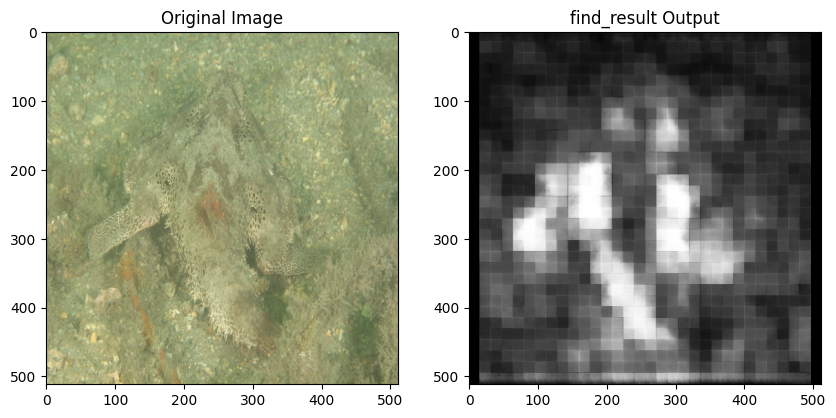

In [ ]:

image_path = '/content/COD10K-v3/Train/Image/COD10K-CAM-1-Aquatic-1-BatFish-3.jpg'
find_result_output = find_result(image_path, generator)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.resize(original_image, (512,512)))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(find_result_output, cmap='gray')
plt.title('find_result Output')

plt.show()

In [5]:
shutil.copytree('/content/drive/MyDrive/Camouflage_Detection/Final_Test','/content/Final_Test')

'/content/Final_Test'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


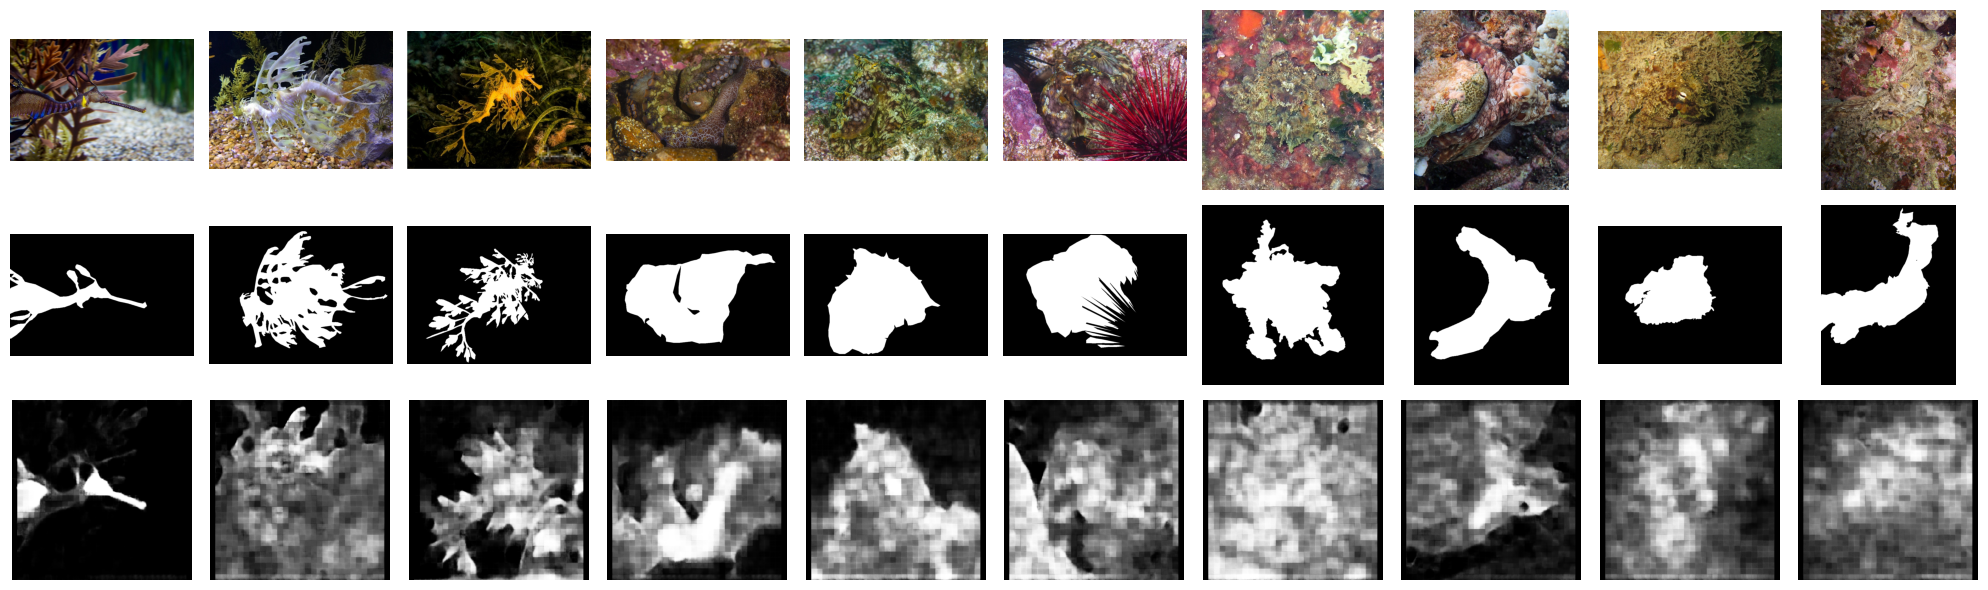

In [13]:
import re
image_dir = '/content/Final_Test/Images'
mask_dir = '/content/Final_Test/Mask'

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
image_files = sorted_alphanumeric(image_files)[5:15]

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, image_file[:-4] + '.png')

    try:
      img = cv2.imread(image_path)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      prediction = find_result(image_path, generator)

      axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axes[0, i].axis('off')
      axes[1, i].imshow(mask, cmap='gray')
      axes[1, i].axis('off')
      axes[2, i].imshow(prediction, cmap='gray')
      axes[2, i].axis('off')

    except Exception as e:
      print(f"Error processing {image_file}: {e}")

plt.tight_layout()
plt.show()